In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from visualisation import Analysis

In [17]:
analysis = {}
##############################################################################
################Input File Name and Plotting Steps############################
##############################################################################
start_time = datetime.now()

#File1 = '200k_sHFPN_Healthy_SD_01_DelaySD_01_run3_V3_TRANSITION'
#File2 = '6e6_sHFPN_Healthy_SD_0_DelaySD_02'
File3 = 'test'
desired_plotting_steps = 10000

#analysis[File1] = Analysis.load_from_file(File1)
#analysis[File2] = Analysis.load_from_file(File2)
analysis[File3] = Analysis.load_from_file(File3)

execution_time = datetime.now()-start_time
print('\n\nLoad-in Time:', execution_time)
print("")
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################   



Load-in Time: 0:00:00.175555



In [25]:
def smoothen(array, filter_size):
    filt=np.ones(filter_size)/filter_size
    return convolve(array[:-(filter_size-1),0],filt)
    
def create_plot(analysis, input_place_list, place_labels, mutation_list, mutation_labels, plot_title):
    t=np.arange(0,(desired_plotting_steps/1000)+0.001,0.001) #

    fig,ax=plt.subplots()
    linestep = 0.3
    line_width = 2.5
    
    for i, mutation in enumerate(mutation_list):
        for place, place_label in zip(input_place_list, place_labels):
            data = analysis[mutation].mean_token_history_for_places([place])[0:desired_plotting_steps+1] #mutation is the file_name
            #print(data[1600000]) #units in time_step
            #print(data[1800000])
            if place_label == "":
                ax.plot(t, data, label = mutation_labels[i], linewidth = line_width- i*linestep, color="black")
            else:
                ax.plot(t, data, label = mutation_labels[i]+' - '+place_label, linewidth = line_width- i*linestep, color="black")
    
    ax.legend()
    Analysis.standardise_plot(ax, title = plot_title, xlabel = "Time (s)",ylabel = "Molecule count")
    

    
##############################################################################
############## OTHER PLOT PARAMETERS YOU WANT#################################
##############################################################################
    plt.xlim([0,20]) #x axis range in seconds
    #plt.ylim([4.335e8,4.345e8]) #y axis range in tokens
    #plt.ylim([0,50])
    
    #DASHED LINES
    # plt.axvline(x=1500, linestyle='--', color ='black')
    # plt.axvline(x=1550, linestyle='--', color ='black')
    #plt.axhline(y=4.34*1e8, linestyle='--', color ='red', label = "fc_t_SNCA_bind_ApoEchol_extra Threshold = 4.34*1e8")
    #plt.axhline(y=10,linestyle='--', color ='red', label ="LB Threshold")
    
    #plt.axhline(y=10,linestyle='--', color ='red', label ="LB Threshold, xmin=0, xmax=1000")
    
    #plt.legend()
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################    
    plt.show()

    ####
def create_plot_transition(analysis, input_transition_list, transition_labels, mutation_list, mutation_labels, plot_title):
    t=np.arange(0,(desired_plotting_steps/1000)+0.001,0.001) #

    fig,ax=plt.subplots()
    linestep = 0.3
    line_width = 2.5
    
    for i, mutation in enumerate(mutation_list):
        for transition, transition_label in zip(input_transition_list, transition_labels):
            data = analysis[mutation].mean_token_history_for_transition_rates([transition])[0:desired_plotting_steps+1] #mutation is the file_name
            #print(data[1600000]) #units in time_step
            #print(data[1800000])
            if transition_label == "":
                ax.plot(t, data, label = mutation_labels[i], linewidth = line_width- i*linestep, color="black")
            else:
                ax.plot(t, data, label = mutation_labels[i]+' - '+transition_label, linewidth = line_width- i*linestep, color="black")
    
    ax.legend()
    Analysis.standardise_plot(ax, title = plot_title, xlabel = "Time (s)",ylabel = "Molecule count")
    
def plot_stacked_bars(ax, legend, all_data, xs, labels, width):

    cum_sum = np.zeros_like(all_data[:,0])
    for i in range(len(labels)):
        data = all_data[:,i]
        rects = ax.bar(xs, data, width, bottom=cum_sum, label=labels[i])
        cum_sum += data    
    
def create_bar_chart(analysis, places_a, places_a_labels, places_b, places_b_labels, mutation_list, mutation_labels, plot_title):
#     for mutation in mutation_list:
#         for place in places_a:
#             print(place)
#             print(analysis[mutation].mean_token_history_for_places(place)[-1])
#     for mutation in mutation_list:
#         for place in places_b:
#             print(place)
#             print(analysis[mutation].mean_token_history_for_places(place)[-1])
    final_token_count_a = [[analysis[mutation].mean_token_history_for_places(place)[-1] for place in places_a] for mutation in mutation_list]
    final_token_count_b = [[analysis[mutation].mean_token_history_for_places(place)[-1] for place in places_b] for mutation in mutation_list]
    print(np.array(final_token_count_a).shape)
    print(np.array(final_token_count_b).shape)
    final_token_count_a = np.sum(final_token_count_a, 2) # remove dimension 3
    final_token_count_b = np.sum(final_token_count_b, 2) # remove dimension 3

    # normalize data

    final_token_count_a = final_token_count_a / np.sum(final_token_count_a[0,:])
    final_token_count_b = final_token_count_b / np.sum(final_token_count_b, 1)[:,None]

    final_token_count_a *= 100
    final_token_count_b *= 100
    
    width = 0.5
    
    FIGURESIZE = (14,7)
    fig, ax = plt.subplots(1, 1, figsize=FIGURESIZE)

    bar_positions_a = np.array(range(len(mutation_list)))
    bar_positions_b = max(bar_positions_a) + 2 + np.array(range(len(mutation_list)))
    
    plot_stacked_bars(ax,legend=mutation_list, all_data=final_token_count_a, xs=bar_positions_a, labels=places_a_labels,width=width)
    plot_stacked_bars(ax,legend=mutation_list, all_data=final_token_count_b, xs=bar_positions_b, labels = places_b_labels,width=width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% Molecule Count', fontsize=16)
    ax.set_title(plot_title, fontsize=18)
    ax.set_xticks(np.concatenate((bar_positions_a, bar_positions_b)))
    ax.set_xticklabels(np.concatenate((mutation_labels, mutation_labels)), rotation=-25, ha='left', fontsize=12)

    #ax.set_ylim((0,150))

    plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()
    
##############################################################################
################Other Relevant Graphs - BSL###################################
##############################################################################
    


    

    


    

##############################################################################
################END ##########################################################
##############################################################################    
    
##############################################################################
################Calcium Relevant Graphs - BSL#################################
##############################################################################

def create_histogram(analysis, bins):
    plt.hist(analysis[File1].delay_list_t_B, bins=bins, edgecolor='black', linewidth=1.2)
    print("NOTE, these are t_B transitions only")
    
def calc_mean_SD_transition(list_of_transition_delays, transition_id):
    """
    So the delays for each transition t_A, t_B t_D were compiled into a list for analysis. We are just calculating the mean and standard deviation for those lists here.
    """
    the_mean_t_A = np.mean(list_of_transition_delays)
    SD_t_A = np.std(list_of_transition_delays)
    print(f"Mean of delay_list {transition_id}:", np.round(the_mean_t_A, decimals=3), "SD:", np.round(100*SD_t_A/the_mean_t_A, decimals=3), "percent", len(list_of_transition_delays), "Counts")    
    print("Max Value:", max(list_of_transition_delays), "Min Value:", min(list_of_transition_delays))
    print("")

def calculate_mean_of_delay(analysis, file):
    print(f"File:{file}")
    t_A = 't_A'
    list_of_transition_delays = analysis[file].delay_list_t_A
    calc_mean_SD_transition(list_of_transition_delays, t_A)
    
    t_B = 't_B'
    list_of_transition_delays = analysis[file].delay_list_t_B
    calc_mean_SD_transition(list_of_transition_delays, t_B)
    
    t_D = 't_D'
    list_of_transition_delays = analysis[file].delay_list_t_D
    calc_mean_SD_transition(list_of_transition_delays, t_D)    
    
    
def create_list_counting_zero_runs(normal_list):
    """
    so in calcium, there is an array of zeros and ones. This function counts the length of zeros the span the array, and appends it to a new list and returns the list
    """
    list_2 = []

    count = 0    
    for index,number in enumerate(normal_list): 
        if number == 0:
            count = count+1
        if number ==1 and normal_list[index-1]==0:
            list_2.append(int(count))
            count = 0
        if number == 0 and index == (len(normal_list)-1): #So situations where we reach the end of the list and we are stuck with a zero are still counted.
            list_2.append(int(count))
    #Cut_off_the very first and last element of the list for safety reasons, to deal with potential truncated zero-runs lowering the mean.
    list_2.pop(0)
    list_2.pop()    

    return list_2

def create_list_counting_one_runs(normal_list):
    """
    so in calcium, there is an array of zeros and ones. This function counts the length of zeros the span the array, and appends it to a new list and returns the list
    """
    list_2 = []

    count = 0    
    for index,number in enumerate(normal_list): 
        if number == 1:
            count = count+1
        if number ==0 and normal_list[index-1]==1:
            list_2.append(int(count))
            count = 0
        if number == 1 and index == (len(normal_list)-1): #So situations where we reach the end of the list and we are stuck with a zero are still counted.
            list_2.append(int(count))
    #Cut_off_the very first and last element of the list for safety reasons, to deal with potential truncated zero-runs lowering the mean.
    list_2.pop(0)
    list_2.pop()    

    return list_2

def calc_and_print_mean_sd_calcium(file, place_id):
    """
    This can take a long time if the list is huge (6million+ time steps).
    data is in a two dimensional form and needs to be converted to a one dimensional list.
    Calculates the Mean number of time steps until that transition contains a one token again and the SD for the place_id over the whole run
    """
    data = analysis[file].mean_token_history_for_places([place_id])[0:desired_plotting_steps+1] 
    list_of_lists = data.tolist()
    normal_list = [item for sublist in list_of_lists for item in sublist]    

    zero_runs_count_list = create_list_counting_zero_runs(normal_list)
    one_runs_count_list = create_list_counting_one_runs(normal_list) 
    mean1 = np.mean(zero_runs_count_list)
    mean2 = np.mean(one_runs_count_list)
    std1 = np.std(zero_runs_count_list)
    std2= np.std(one_runs_count_list)
    print(f"Mean Delay for {place_id}:", np.round(mean1, decimals =3), "timesteps", len(zero_runs_count_list), "counts")
    print(f"SD for {place_id}: +/-", np.round(std1, decimals=3), "timesteps or", np.round(100*std1/mean1, decimals=3), "%") 
    print("Max:", max(zero_runs_count_list), "Min:", min(zero_runs_count_list))
    #print("The very first element was:", zero_runs_count_list[0]) 
    #print("The very last element was: ", zero_runs_count_list[len(zero_runs_count_list)-1])     
    print('')
    print(f"Mean Time Active for {place_id}:", np.round(mean2, decimals =3), "timesteps", len(one_runs_count_list), "counts")
    print(f"SD for {place_id}: +/-", np.round(std2, decimals=3), "timesteps or", np.round(100*std2/mean2, decimals=3), "%") 
    print("Max:", max(one_runs_count_list), "Min:", min(one_runs_count_list))
    print('')
    print('#########################')
def calculate_TRUE_calcium_stochasticity(file):
    print(f"File: {file}")
    place_id = 'p_on4'
    calc_and_print_mean_sd_calcium(file, place_id)
    place_id = 'p_Ca_extra'
    calc_and_print_mean_sd_calcium(file, place_id)
    place_id = 'p_on3'
    calc_and_print_mean_sd_calcium(file, place_id)
    
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################  

In [15]:
##############################################################################
###########Rate Relevant Graphs - BSL - List of List version - OBSOLETE#######
##############################################################################
def return_list_of_means_calculated_froms_bins_from_list(normal_list,bin_width):
    """
    takes a flat list containing all tokens you want, and returns a list shrunk by the factor of bin_width.
    Purpose is for stochastic plots, where you want to take the mean over a bin, to reduce excessive stochasticity which when plotted produces fat fluctuations which hides the overall trend.
    bin_width should be in time_steps and total timesteps/bin_width should equal an integer
    """
    bin_number = desired_plotting_steps/bin_width
    start = 0
    end = bin_width
    list_of_means = [0]
    for item in range(int(bin_number)):
        list_of_means.append(np.mean(normal_list[start:end]))
        start = start + bin_width
        end = end + bin_width
    return list_of_means
#Transition Specific Rates Functions
def return_flat_list_for_transition_rate(file, transition_id):
    LofL_of_tokens_transferred_for_each_transition_per_timestep = analysis[file].list_of_list_of_tokens_transferred_for_each_transition_per_timestep
    number_of_time_steps = len(LofL_of_tokens_transferred_for_each_transition_per_timestep)
    transition_id_index = analysis[file].transition_dict.get(transition_id)
    new_list =[]
    for time_step in range(number_of_time_steps):
        new_list.append(LofL_of_tokens_transferred_for_each_transition_per_timestep[time_step][transition_id_index])#first number is the timestep, second number is the transition_id_index
    flat_list = [item for sublist in new_list for item in sublist]
    if len(flat_list) == 2*number_of_time_steps:
        list_1=[]
        list_2=[]
        for index,item in enumerate(flat_list):
            if index%2==0:
                list_1.append(item)
            else:
                list_2.append(item)
        return list_1, list_2
    return flat_list
def plot_tokens_produced_from_each_TRANSITION(file, transition_id, color, bin_width):
    """
    bin_width of 1000 means token rate per second is plotted, if sHFPN time_step was set to 0.001
    """
    flat_list=return_flat_list_for_transition_rate(file,transition_id)
    if len(flat_list)==2:
        list_1, list_2 = return_flat_list_for_transition_rate(file,transition_id)
        binned_list1 =return_list_of_means_calculated_froms_bins_from_list(list_1, bin_width)
        binned_list2 = return_list_of_means_calculated_froms_bins_from_list(list_2, bin_width)
        plt.plot(binned_list1, label=transition_id+" Output 1")
        plt.plot(binned_list2, label=transition_id+" Output 2")     
        plt.ylabel("Token Rate Per Second")
        plt.legend()
    else:
        binned_list=return_list_of_means_calculated_froms_bins_from_list(flat_list, bin_width)
        plt.plot(binned_list, label=transition_id, color=color)
        plt.ylabel("Token Rate Per Second")
        plt.legend()
    
#Place Specific Rates Functions

def return_list_of_rate_of_change_for_place(random_list):
    empty_list = [0]
    stop = len(random_list)-1
    for index,item in enumerate(random_list):
        if index == stop:
            return empty_list
        if index<len(random_list):
            empty_list.append(random_list[index+1]-random_list[index])
            
def plot_rate_for_place(file, place_id, color,bin_width): 
    data = analysis[file].mean_token_history_for_places([place_id])[0:desired_plotting_steps+1] 
    list_of_lists = data.tolist()
    normal_list = [item for sublist in list_of_lists for item in sublist]   
    rate_list_of_place = return_list_of_rate_of_change_for_place(normal_list)
    binned_rate_list_of_place= return_list_of_means_calculated_froms_bins_from_list(rate_list_of_place,bin_width)
    plt.plot(binned_rate_list_of_place, label=place_id, color=color)
    plt.legend()





#print(analysis[File1].list_of_list_of_tokens_transferred_for_each_transition_per_timestep)#15 16 17
#print(analysis[File1].transition_dict)




,t_ETC p_ATP,t_ETC p_ROS_mito
0,NaN,NaN
1,55117.2,12.5266
2,60974.6,13.8579
3,59415.6,13.5035
4,58058.1,13.195
...,...,...
996,3.4083e+06,774.614
997,2.55097e+06,579.767
998,2.57653e+06,585.575
999,3.30679e+06,751.542


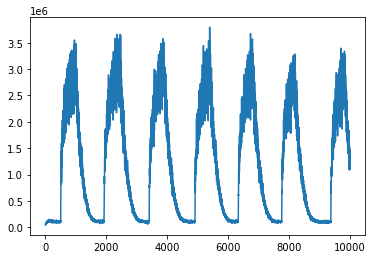

In [18]:
##############################################################################
###################Rate Analytics - panda version - BSL ######################
##############################################################################
dataframe = analysis[File3].df_for_rate_analytics
#print(dataframe)
dataframe[["t_LDLR_endocyto p_ApoEchol_EE"]]
dataframe[["t_ETC p_ATP", "t_ETC p_ROS_mito"]]

plt.plot(dataframe[["t_ETC p_ATP"]])

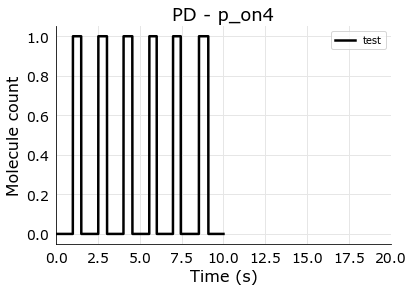



Plotting Time: 0:00:00.209402


In [31]:
##############################################################################
################Plotting Commands - BSL#######################################
##############################################################################
start_time = datetime.now()

#print(calculate_mean_per_bin(File2, "p_ROS_mito",1000000)) # doesnt work anymore, need to make a new function called array_to_list that converts data to a normal list

#calculate_TRUE_calcium_stochasticity(File1)
#calculate_TRUE_calcium_stochasticity(File2)
#plot_rate_for_place(File1,"p_chol_mito", bin_width = 1000)
#plot_tokens_produced_from_each_TRANSITION(File1, "t_chol_trans_LE_mito", bin_width=1000) 
#plot_tokens_produced_from_each_TRANSITION(File1, "t_CYP11A1_metab", bin_width=1000) 
#plot_tokens_produced_from_each_TRANSITION(File1, "t_CYP27A1_metab", bin_width=1000) 
#plot_tokens_produced_from_each_TRANSITION(File1, "t_chol_trans_ER_mito", bin_width=1000) 

create_plot(analysis, 
            input_place_list = ['p_on4'], 
            place_labels = [""], 
            mutation_list = [File3], 
            mutation_labels = [File3],
            plot_title = 'PD - p_on4')

#create_plot(analysis, 
#            input_place_list = ['p_on4'], 
#            place_labels = [""], 
#            mutation_list = [File2], 
#            mutation_labels = [File2],
#            plot_title = 'PD - p_on4')

#create_plot_transition(analysis, 
#            input_transition_list = ['t_chol_trans_ER_mito'], 
#            transition_labels = [""], 
#            mutation_list = [File2], 
#            mutation_labels = [File2],
#            plot_title = 'PD - t_chol_trans_ER_mito')

# create_histogram(analysis, 20)

# calculate_mean_of_delay(analysis, File1)
# calculate_mean_of_delay(analysis, File2)

execution_time = datetime.now()-start_time
print('\n\nPlotting Time:', execution_time)
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################  

In [28]:
production_coefficients = [2,2]

reaction_speed_function = lambda a : rate_constant * a['p_H2']**2 * a['p_O2']**1

function = lambda f, n : lambda a : f(a) * n 

production_speed_functions  = [function(reaction_speed_function, pc) for pc in production_coefficients]

print(production_speed_functions) #list of 

[<function <lambda>.<locals>.<lambda> at 0x0000018E993A0160>, <function <lambda>.<locals>.<lambda> at 0x0000018E993A01F0>]


In [29]:
production_speed_functions  = [lol for lol in production_coefficients]
print(production_speed_functions)

[2, 2]


In [30]:
output_place_ids = ["output_place_1","output_place_2","output_place_3"]
production_speed_functions = [4,5,6]

production_speeds = []
for x,y in zip(test, yo):
    production_speeds.append

NameError: name 'test' is not defined

In [ ]:
test = ["oi","ya","ya"]
print(test)

In [ ]:
a = np.array([1.0, np.nan, 2.0])
print(a)
a= np.append(a, 3)
print(a)
np.nanmax(a)

In [ ]:
calculated_tokens_list = np.array([1,np.nan,9])
consumption_coefficients= [2,2,2]

deciding_value_list = [i/j for i,j in zip(calculated_tokens_list,consumption_coefficients)]

print(deciding_value_list)

index_min = np.nanargmin(deciding_value_list)
print(index_min)

In [ ]:
check_flag = np.array([10,0,0,0])

if any(check_flag):
    print("flag")
else:
    print("nothing")

In [ ]:

list_len = 4
consuming_tokens = np.zeros(list_len)
print(consuming_tokens)

In [1]:
for x,y in enumerate([1,321,124211,1215,215,215215,215,]):
    print(x,y)

0 1
1 321
2 124211
3 1215
4 215
5 215215
6 215


In [ ]:

for x in :

#enumerate counts from zero
count = 0
for global_trans_index, trans in enumerate(self.transitions.values()):
    for specific_trans_index, production_coefficients in enumerate(trans.production_coefficients):
        #1) append 0 to array
        #2) trans_id = key,  count (is value associated with the key) )
        #2) count = count +1
#listtt = np.zeros(counter+1)

import pandas as pd
import numpy as np

df = pd.DataFrame(columns=("a","b"), index=np.arange(1,1000001))
print(df)